### Exercise 02 - Wordembeddings


In [85]:
# All imports for the whole file are displayed here
import pandas as pd
from io import StringIO
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import string
import re
import urllib.request
from collections import Counter

In a first step we load the data into the notebook using the URL provided in the task description. This might not work on a local jupyter notebook. Furthermore is it important to notice that this notebook takes long to train. It is therefore recommended to use GPUs (Edit -> Notebook settings -> GPU)

In [8]:
# URL for both data files
url_hotel_reviews = 'https://drive.google.com/file/d/1ihP1HZ8YHVGGIEp1RHxXdt3PPIi12xvL/view?usp=sharing'
url_scifi_text = 'https://drive.google.com/file/d/10ehW4jZND3QA29v9aNboYUett5-swuNe/view?usp=sharing'

def load_dataset(url):
    url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
    df = pd.read_csv(url2)
    df.columns = ['review', 'rating']
    return df

In [9]:
# load both data sets into the notebook
df_hotel_reviews = load_dataset(url_hotel_reviews)
df_hotel_reviews.head()

,review,rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [10]:
url3='https://drive.google.com/uc?id=' + url_scifi_text.split('/')[-2]
data = urllib.request.urlopen(url3)
# decode is used to convert the bytes to string
scifi_string = data.read().decode("UTF-8")

print(scifi_string[:100])

MARCH # All Stories New and Complete Publisher Editor IF is published bi-monthly by Quinn Publishing


## Preprocessing the Data
We removed all words, integers and numbers. We than set the whole text to lowercase. This way we really have an embedding of only words and we don't superficially enlarge it with uppercase words.

In [11]:
bad_chars = ['!','"','#','$','%','&','\'','(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '1', '2', '3', '4', '5', '6','7', '8', '9', '0']

def preprocess_text(text):
  # remove all bad chars
  text = ''.join(filter(lambda i: i not in bad_chars, text))
  # remove multiple spaces such as \t and \n
  text = " ".join(text.split())
  text = text.lower()
  return text

First we convert the hotel text into a processable string. Therefore we remove punctuation and all integers. Additionally all tabs (\t) and (\n) are removed.
In the end everything is lowered to lower case

In [12]:
# create one big text
raw_text_hotel = df_hotel_reviews["review"].apply(''.join)
print(raw_text_hotel)
# make one string out of the column
raw_text_hotel = raw_text_hotel.str.cat(sep=" ")
raw_text_hotel = preprocess_text(raw_text_hotel)

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice rooms not 4* experience hotel monaco seat...
3        unique, great stay, wonderful time hotel monac...
4        great stay great stay, went seahawk game aweso...
                               ...                        
20486    best kept secret 3rd time staying charm, not 5...
20487    great location price view hotel great quick pl...
20488    ok just looks nice modern outside, desk staff ...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking, ca n't believe excellent ratin...
Name: review, Length: 20491, dtype: object


Afterwards the same is done with the scifi data

In [13]:
raw_text_scifi = preprocess_text(scifi_string)
print(raw_text_scifi[:100])

march all stories new and complete publisher editor if is published bimonthly by quinn publishing co


## Train Models

#### Train Model on the Hotel Review Excel Sheet


In [76]:
torch.manual_seed(1)

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

def prepare_for_model(raw_text):
  raw_text = raw_text.split()
  # limit the nr of words.
  raw_text = raw_text[:10000]
  # By deriving a set from `raw_text`, we deduplicate the array
  # a set has the advantage that only unique values are taken
  vocab = set(raw_text)
  vocab_size = len(vocab)

  # generates dictionary with index of each word in the vocabulary
  word_to_ix = {word: i for i, word in enumerate(vocab)}
  index_to_word = {idx: w for idx, w in enumerate(vocab)}

  # The code below than creates tuples where on the one side we have an array of neighboring words
  # and on the other side we have the target word
  # Example: For a window size of 2 for the word about we get ([we, are, to, study], about)
  data = []
  for i in range(2, len(raw_text) - 2):
      context = [raw_text[i - 2], raw_text[i - 1],
                raw_text[i + 1], raw_text[i + 2]]
      target = raw_text[i]
      data.append((context, target))
  return data, word_to_ix, vocab, index_to_word

Shown below is the output of the prepare for model function from the raw_text example

In [15]:
prepare_for_model(raw_text)[0][:5]

[(['We', 'are', 'to', 'study'], 'about'),
 (['are', 'about', 'study', 'the'], 'to'),
 (['about', 'to', 'the', 'idea'], 'study'),
 (['to', 'study', 'idea', 'of'], 'the'),
 (['study', 'the', 'of', 'a'], 'idea')]

In the following cell we define the CBOW model which is used for training. It includes two hidden linear layers which are denly connected. Between the two layers a Relu activation function is used. In the end a LogSoftmax activation function is used to compute the output.

In [16]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        # we create an embedding of this size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # left (context * embedding_dim) is the input, while the right (128) is the dim of the ouput vector to the 
        # next layer 
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        self.relu_activation = nn.ReLU()
        self.log_activation = nn.LogSoftmax(dim=1)

    def forward(self, inputs):
        # we need to retrieve the weights (embeddings) for each word 
        # these embeddings will be learned in the backward pass
        # after retrivial the matrix (multiple words) needs to be flattened
        embeds = self.embeddings(inputs).view((1, -1))
        # forward the embedding towards the output
        linear_1 = self.linear1(embeds)
        activated_1 = self.relu_activation(linear_1)
        linear_2 = self.linear2(activated_1)
        output = self.log_activation(linear_2)
        return output

We define a training function

In [17]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

def train_model(model, training_data, epochs, word_to_ix):
  losses = []
  epochs_arr = []
  loss_function = nn.NLLLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01)

  for epoch in range(epochs):
      total_loss = 0
      for context, target in training_data:

          # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
          # into integer indices and wrap them in tensors)
          context_idxs = make_context_vector(context, word_to_ix)

          # Step 2. Recall that torch *accumulates* gradients. Before passing in a
          # new instance, you need to zero out the gradients from the old
          # instance
          model.zero_grad()

          # Step 3. Run the forward pass, getting log probabilities over next
          # words
          log_probs = model(context_idxs)

          # Step 4. Compute your loss function. (Again, Torch wants the target
          # word wrapped in a tensor)
          # log_probs are the predictions and the other thing is the true target
          loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

          # Step 5. Do the backward pass and update the gradient
          loss.backward()
          # update the gradient
          optimizer.step()

          # Get the Python number from a 1-element Tensor by calling tensor.item()
          total_loss += loss.item()
      
      # print only every 
      print('Epoch:', epoch, '\tLoss:', loss.item())
      losses.append(total_loss)
      epochs_arr.append(epoch)

  print("""---------------------------------------------------------------------
    \n Finished training \n ---------------------------------------------------------------------""")
  
  return epochs_arr, losses

Afterwards we train the model with the Hotel Review Data

Epoch: 0 	Loss: 3.020556926727295
Epoch: 1 	Loss: 0.8522582650184631
Epoch: 2 	Loss: 0.2631464898586273
Epoch: 3 	Loss: 0.21960604190826416
Epoch: 4 	Loss: 0.20861157774925232
Epoch: 5 	Loss: 0.112159863114357
Epoch: 6 	Loss: 0.04470289126038551
Epoch: 7 	Loss: 0.010499123483896255
Epoch: 8 	Loss: 0.01121950801461935
Epoch: 9 	Loss: 0.004470592364668846
Epoch: 10 	Loss: 0.0007890925044193864
Epoch: 11 	Loss: 0.00023719835735391825
---------------------------------------------------------------------
    
 Finished training 
 ---------------------------------------------------------------------


Text(0, 0.5, 'Loss')

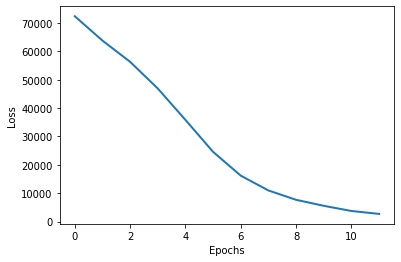

In [48]:
EMBEDDING_DIM = 12
EMBEDDING_DIM_HOTEL = 50
EPOCHS_HOTEL = 12
CONTEXT_SIZE = 4  # 2 words to the left, 2 to the right

data_hotel, word_to_ix_hotel, vocab_hotel, index_to_word_hotel = prepare_for_model(raw_text_hotel)
model_hotel = CBOW(len(vocab_hotel), EMBEDDING_DIM_HOTEL, CONTEXT_SIZE)
epoch, loss = train_model(model_hotel, data_hotel, EPOCHS_HOTEL, word_to_ix_hotel)


plt.plot(epoch, loss, linewidth=2.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')


Than we train our dataset with the Sci_Fi dataset